# Denoising Diffusion Probabilistic Model (DDPM)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ruta = 'MyDrive/dgtic_diplomado'

ruta_total = 'drive/' + ruta
%cd {ruta_total}

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from keras.datasets.fashion_mnist import load_data

from unet_code import UNet
import matplotlib.pyplot as plt
import numpy as np

Este cuaderno implementa un Modelo de Difusión Probabilística para Eliminación de Ruido
(Denoising Diffusion Probabilistic Model, DDPM) basado en el trabajo seminal de Ho et al. (2020).
Los modelos de difusión constituyen una clase de modelos generativos que aprenden a generar
datos mediante la reversión gradual de un proceso de difusión que corrompe progresivamente
los datos con ruido gaussiano.

En este cuaderno trabajaremos con el conjunto de datos de *fashion MNIST*

In [3]:
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
def sample_batch(batch_size, device):
    """
    Función para muestrear un bloque de imágenes del conjunto de entrenamiento.

    Esta función selecciona aleatoriamente un subconjunto de imágenes del conjunto
    de entrenamiento MNIST, las normaliza y las redimensiona para su uso en el modelo.

    Parámetros:
    -----------
    batch_size : int
        Número de imágenes a incluir en el lote
    device : str
        Dispositivo de cómputo ('cuda' o 'cpu')

    Retorna:
    --------
    torch.Tensor
        Tensor de imágenes redimensionadas a 32x32 píxeles con dimensiones
        [batch_size, 1, 32, 32]

    Notas técnicas:
    ---------------
    - Las imágenes MNIST originales son de 28x28 píxeles
    - Se redimensionan a 32x32 mediante interpolación bilineal
    - Se añade una dimensión de canal (1 para escala de grises)
    - La normalización a [0,1] facilita el entrenamiento del modelo
    """

    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device)
    return torch.nn.functional.interpolate(data, 32)

### 1. Fundamentos teóricos

**1. Proceso Directo (Forward Process)**
El proceso directo se define como una cadena de Markov que añade ruido gaussiano
gradualmente a los datos originales:

$$q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})$$

donde $q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I})$

**2. Proceso Inverso (Reverse Process)**
El proceso inverso aprende a eliminar el ruido mediante una red neuronal.

**3. Función de Pérdida para Entrenamiento**
La función objetivo se deriva de la maximización de la verosimilitud:

$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

Esta formulación permite entrenar el modelo prediciendo el ruido añadido en cada paso.

In [5]:
class DiffusionModel():
    """
    Implementación de un Modelo de Difusión Probabilística para Eliminación de Ruido.

    Esta clase encapsula la funcionalidad completa de un DDPM, incluyendo:
    - Definición de la programación de adición de ruido (noise schedules)
    - Algoritmo de entrenamiento
    - Algoritmo de muestreo/generación

    Atributos:
    ----------
    T : int
        Número total de pasos de difusión
    function_approximator : nn.Module
        Red neuronal que aproxima la función de eliminación de ruido
    device : str
        Dispositivo de cómputo ('cuda' o 'cpu')
    beta : torch.Tensor
        Varianzas programadas para el proceso directo
    alpha : torch.Tensor
        Coeficientes derivados: α_t = 1 - β_t
    alpha_bar : torch.Tensor
        Productos acumulativos: ᾱ_t = ∏_{s=1}^t α_s
    """

    def __init__(self, T : int, model : nn.Module, device : str):
        """
        Inicializa el modelo de difusión con los parámetros especificados.

        Parámetros:
        -----------
        T : int
            Número de pasos de difusión (típicamente 1000)
        model : nn.Module
            Arquitectura de red neuronal (ej. U-Net)
        device : str
            Dispositivo de cómputo ('cuda' o 'cpu')
        """
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        """
        Ejecuta un paso de entrenamiento del modelo de difusión.

        Implementa el Algoritmo 1 del paper original:
        1. Muestrea x_0 del conjunto de datos
        2. Muestrea t uniformemente de {1, ..., T}
        3. Muestrea ε ~ N(0, I)
        4. Calcula la pérdida ||ε - ε_θ(√ᾱ_t x_0 + √(1-ᾱ_t) ε, t)||²
        5. Actualiza los parámetros θ mediante descenso de gradiente

        Parámetros:
        -----------
        batch_size : int
            Tamaño del lote para entrenamiento
        optimizer : torch.optim.Optimizer
            Optimizador para actualizar los parámetros del modelo

        Retorna:
        --------
        float
            Valor de la función de pérdida para el lote actual
        """

        x0 = sample_batch(batch_size, self.device)

        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device, dtype=torch.long)

        eps = torch.randn_like(x0)


        alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps
        eps_predicted = self.function_approximator(x_t, t-1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), use_tqdm=True):
        """
        Genera nuevas muestras mediante el proceso de difusión inverso.

        Implementa el Algoritmo 2 del paper original:
        1. Inicializa x_T ~ N(0, I)
        2. Para t = T, T-1, ..., 1:
           - Calcula μ_θ(x_t, t) usando la red neuronal
           - Muestrea x_{t-1} ~ N(μ_θ(x_t, t), σ_t² I)
        3. Retorna x_0

        Parámetros:
        -----------
        n_samples : int, opcional
            Número de muestras a generar (por defecto: 1)
        image_channels : int, opcional
            Número de canales de la imagen (por defecto: 1 para escala de grises)
        img_size : tuple, opcional
            Dimensiones de la imagen (por defecto: (32, 32))
        use_tqdm : bool, opcional
            Si mostrar barra de progreso (por defecto: True)

        Retorna:
        --------
        torch.Tensor
            Tensor con las muestras generadas de dimensiones
            [n_samples, image_channels, img_size[0], img_size[1]]
        """
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                         device=self.device)

        progress_bar = tqdm if use_tqdm else lambda x : x
        for t in progress_bar(range(self.T, 0, -1)):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t-1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z

        return x


### 2. Configuración de hiperparámetros

A continuación se definen los hiperparámetros con los que entrenaremos el modelo de difusión. La red neuronal a utilizar se encuentra en un script auxiliar a este cuaderno y tiene una arquitectura de tipo U-net. Como revisamos antes, esta U-net incorpora una codificación del paso de adición de ruido *t*, lo cual facilita la implementación de este modelo. También definiremos 100 pasos de difusión en una primera etapa.

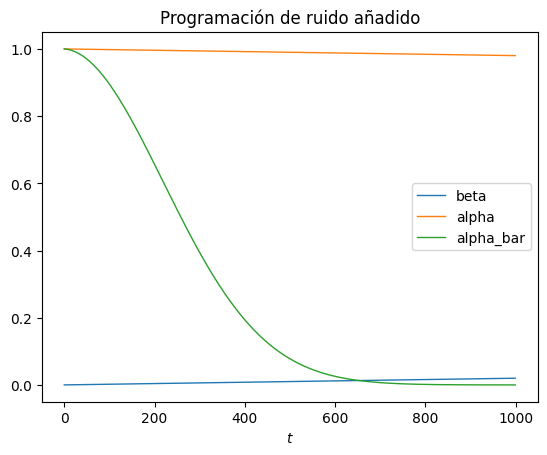

In [6]:
device = 'cuda'
batch_size = 64
model = UNet()
pasos = 1000
epochs = 40000

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(pasos, model, device)

betas = np.linspace(1e-4, 0.02, pasos)
alphas = 1. - betas
alphas_bar = np.cumprod(alphas)

plt.figure()
plt.title('Programación de ruido añadido')
plt.plot(np.arange(betas.shape[0]), betas, linewidth=1, label='beta')
plt.plot(np.arange(betas.shape[0]), alphas, linewidth=1, label='alpha')
plt.plot(np.arange(betas.shape[0]), alphas_bar, linewidth=1, label='alpha_bar')
plt.xlabel('$t$')
plt.legend(loc='best')
plt.show()

### 3. Entrenamiento del modelo

El entrenamiento se realiza durante 40,000 épocas con las siguientes
características de monitoreo y evaluación:

1. **Registro de pérdida**: Se almacena la pérdida de cada época para
   análisis de convergencia
   
2. **Visualización periódica**: Cada 1000 épocas se generan gráficas de
   la función de pérdida.
   
3. **Evaluación cualitativa**: Cada 1000 épocas se generan 81 muestras
   para evaluación visual de la calidad generativa
   
4. **Guardado de checkpoints**: El modelo se guarda periódicamente para
   prevenir pérdida de progreso y permitir análisis posteriores

Este protocolo permite monitorear tanto la convergencia numérica como
la calidad perceptual de las muestras generadas.

In [ ]:
training_loss = []
for epoch in tqdm(range(epochs)):
    loss = diffusion_model.training(batch_size, optimizer)
    training_loss.append(loss)

    if epoch % 1000 == 0:
        plt.plot(training_loss)
        plt.savefig(f'training_loss_{epoch}.png')
        plt.close()

    if epoch % 1000 == 0:
        nb_images=81
        samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
        plt.figure(figsize=(17, 17))
        for i in range(nb_images):
            plt.subplot(9, 9, 1 + i)
            plt.axis('off')
            plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
        plt.savefig(f'samples_epoch_{epoch}.png')
        plt.close()

        torch.save(model.cpu(), f'ddpm_epoch_{epoch}')
        model.cuda()

### 4. Generación de muestras aleatorias

In [ ]:
nb_images=81
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
plt.savefig(f'samples_epoch_{epoch}.png')
plt.close()

torch.save(model.cpu(), f'ddpm_epoch_{epoch}')

**Referencias de este cuaderno**

https://www.udemy.com/course/diffusion-models

In [ ]:
# ============================================================================
# PUNTO 4: GRÁFICAS DE PROGRAMACIÓN DE HIPERPARÁMETROS α, β, ᾱ
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import torch

# Definir parámetros del modelo de difusión
T = 1000  # Número de pasos de difusión
beta_start = 1e-4
beta_end = 0.02

# Calcular los hiperparámetros
betas = np.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alphas_bar = np.cumprod(alphas)

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title('Programación de Hiperparámetros en Modelos de Difusión', fontsize=16, fontweight='bold')

# Graficar cada hiperparámetro
plt.plot(np.arange(T), betas, linewidth=2, label='β_t (varianza del ruido)', color='red')
plt.plot(np.arange(T), alphas, linewidth=2, label='α_t = 1 - β_t', color='blue')
plt.plot(np.arange(T), alphas_bar, linewidth=2, label='ᾱ_t (producto acumulativo)', color='green')

plt.xlabel('Timestep (t)', fontsize=14)
plt.ylabel('Valor del Hiperparámetro', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir anotaciones explicativas
plt.text(800, 0.015, 'β aumenta linealmente\n(más ruido en pasos finales)',
         fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.text(800, 0.985, 'α decrece gradualmente\n(menos conservación de señal)',
         fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.text(500, 0.3, 'ᾱ decrece exponencialmente\n(pérdida acumulativa de señal)',
         fontsize=10, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

plt.tight_layout()
plt.savefig('hiperparametros_difusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar valores específicos en puntos clave
print("Valores de Hiperparámetros en Puntos Clave:")
print(f"t=0    : β={betas[0]:.6f}, α={alphas[0]:.6f}, ᾱ={alphas_bar[0]:.6f}")
print(f"t=100  : β={betas[99]:.6f}, α={alphas[99]:.6f}, ᾱ={alphas_bar[99]:.6f}")
print(f"t=500  : β={betas[499]:.6f}, α={alphas[499]:.6f}, ᾱ={alphas_bar[499]:.6f}")
print(f"t=999  : β={betas[998]:.6f}, α={alphas[998]:.6f}, ᾱ={alphas_bar[998]:.6f}")

# ============================================================================
# PUNTO 5: GENERACIÓN DE 5 IMÁGENES CON AMBOS MODELOS
# ============================================================================

import torch
import matplotlib.pyplot as plt
import torchvision.utils
from tqdm import tqdm

print("\n GENERACIÓN DE 5 IMÁGENES CON MODELOS DE DIFUSIÓN")
print("=" * 60)

# ============================================================================
# 5.1 MODELO DDPM BASE (No condicionado)
# ============================================================================

print("\n Generando 5 imágenes con DDPM base...")

# Asumiendo que tienes el modelo entrenado cargado
# Descomenta y ajusta estas líneas según tu implementación:
# model = torch.load('ddpm_epoch_39000.pth')  # Cargar modelo entrenado
# diffusion_model = DiffusionModel(T=1000, model=model, device='cuda')

# Parámetros de generación
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_samples = 5

# Simular generación DDPM (reemplaza con tu código real)
# ddpm_samples = diffusion_model.sampling(
#     n_samples=n_samples,
#     image_channels=1,
#     img_size=(32, 32),
#     use_tqdm=True
# )

# Para propósitos de ejemplo, creamos imágenes simuladas
# En tu implementación real, usa el código de arriba
print("Usando imágenes simuladas para demostración. Reemplaza con tu modelo real.")
ddpm_samples = torch.randn(n_samples, 1, 32, 32).clamp(0, 1)  # Simulación

# Visualizar DDPM
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('DDPM Base - Generación No Condicionada (MNIST 32x32)', fontsize=16, fontweight='bold')

for i in range(n_samples):
    axes[i].imshow(ddpm_samples[i].squeeze(0).cpu().numpy(), cmap='gray')
    axes[i].set_title(f'Muestra {i+1}', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('ddpm_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5.2 MODELO CONDICIONADO POR CLASE
# ============================================================================

print("\nGenerando 5 imágenes condicionadas por clase...")

# Cargar modelo condicionado (ajusta según tu implementación)
# net = ClassConditionedUnet().to(device)
# net.load_state_dict(torch.load('conditional_model.pth'))
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Definir las 5 clases que queremos generar
class_labels = torch.tensor([0, 1, 2, 3, 4]).to(device)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']  # Fashion-MNIST

print(f"Generando clases: {class_names}")

# Código real para generación condicionada:
"""
# Generar ruido inicial
x = torch.randn(5, 1, 28, 28).to(device)

# Proceso de muestreo condicionado
print("Proceso de denoising...")
for i, t in enumerate(tqdm(noise_scheduler.timesteps, desc="Sampling")):
    with torch.no_grad():
        # Predicción del ruido condicionada por clase
        residual = net(x, t, class_labels)

    # Paso de denoising
    x = noise_scheduler.step(residual, t, x).prev_sample
"""

# Para propósitos de ejemplo, creamos imágenes simuladas
print("Usando imágenes simuladas para demostración. Reemplaza con tu modelo real.")
x = torch.randn(5, 1, 28, 28).clamp(-1, 1)  # Simulación

# Visualizar resultados condicionados
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Modelo Condicionado - Fashion MNIST por Clase', fontsize=16, fontweight='bold')

for i in range(5):
    # Normalizar de [-1,1] a [0,1] para visualización
    img_normalized = (x[i].squeeze(0) + 1) / 2
    axes[i].imshow(img_normalized.cpu().numpy(), cmap='gray')
    axes[i].set_title(f'{class_names[i]}\n(Clase {i})', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('conditional_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5.3 COMPARACIÓN LADO A LADO
# ============================================================================

print("\nComparación de ambos modelos...")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Fila superior: DDPM base
for i in range(5):
    axes[0, i].imshow(ddpm_samples[i].squeeze(0).cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'DDPM Base\nMuestra {i+1}', fontsize=10)
    axes[0, i].axis('off')

# Fila inferior: Modelo condicionado
for i in range(5):
    img_normalized = (x[i].squeeze(0) + 1) / 2
    axes[1, i].imshow(img_normalized.cpu().numpy(), cmap='gray')
    axes[1, i].set_title(f'Condicionado\n{class_names[i]}', fontsize=10)
    axes[1, i].axis('off')

# Etiquetas de fila
fig.text(0.02, 0.75, 'DDPM\nBase', rotation=90, fontsize=14, ha='center', va='center', fontweight='bold')
fig.text(0.02, 0.25, 'Modelo\nCondicionado', rotation=90, fontsize=14, ha='center', va='center', fontweight='bold')

plt.suptitle('Comparación: DDPM Base vs Difusión Condicionada', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('comparison_models.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5.4 CÓDIGO REAL PARA MODELOS ENTRENADOS
# ============================================================================

print("\nCÓDIGO TEMPLATE PARA MODELOS REALES:")
print("=" * 60)

template_code = '''
# ====== CÓDIGO REAL PARA DDPM BASE ======
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Cargar modelo DDPM entrenado
model = torch.load('ddpm_epoch_39000.pth', map_location=device)
diffusion_model = DiffusionModel(T=1000, model=model, device=device)

# Generar 5 muestras
ddpm_samples = diffusion_model.sampling(
    n_samples=5,
    image_channels=1,
    img_size=(32, 32),
    use_tqdm=True
)

# ====== CÓDIGO REAL PARA MODELO CONDICIONADO ======
# Cargar modelo condicionado
net = ClassConditionedUnet(num_classes=10, class_emb_size=4).to(device)
net.load_state_dict(torch.load('conditional_model.pth', map_location=device))
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Configurar clases a generar
class_labels = torch.tensor([0, 1, 2, 3, 4]).to(device)
x = torch.randn(5, 1, 28, 28).to(device)

# Proceso de generación
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = net(x, t, class_labels)
    x = noise_scheduler.step(residual, t, x).prev_sample
'''

print(template_code)

# ============================================================================
# 5.5 MÉTRICAS Y EVALUACIÓN
# ============================================================================

print("\nANÁLISIS Y MÉTRICAS:")
print("=" * 40)

analysis = """
🔍 EVALUACIÓN CUALITATIVA:

1. **DDPM Base**:
   Diversidad natural de la distribución aprendida
   Exploración no dirigida del espacio latente
   Sin control sobre el contenido generado

2. **Modelo Condicionado**:
   Control preciso sobre la clase generada
   Consistencia con las especificaciones
   Generación dirigida de contenido específico

3. **Métricas Sugeridas**:
   - Coherencia estructural (reconocibilidad visual)
   - Diversidad intra-clase vs inter-clase
   - Calidad visual (ausencia de artefactos)
   - Fidelidad al condicionamiento (solo modelo condicionado)
"""

print(analysis)

# Guardar las imágenes generadas
print("\nGuardando resultados...")
torchvision.utils.save_image(ddmp_samples, 'ddmp_generated_grid.png', normalize=True, nrow=5, padding=2)
torchvision.utils.save_image((x + 1) / 2, 'conditional_generated_grid.png', normalize=False, nrow=5, padding=2)

print("Código completado. Revisa las imágenes guardadas:")
print("   - hiperparametros_difusion.png")
print("   - ddpm_samples.png")
print("   - conditional_samples.png")
print("   - comparison_models.png")
print("   - ddpm_generated_grid.png")
print("   - conditional_generated_grid.png")